In [15]:
!/opt/bin/nvidia-smi

Tue Apr 14 18:10:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# % cp -r /content/drive/My\ Drive/Colab\ Notebooks/age_classification/agedata_cut.zip /content
# ! unzip /content/agedata_cut.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/agedata_cut/26_1_2_20170116184827669.jpg  
  inflating: /content/agedata_cut/68_1_0_20170110175311202.jpg  
  inflating: /content/agedata_cut/2_0_0_20161219161216590.jpg  
  inflating: /content/agedata_cut/24_1_3_20170104231923674.jpg  
  inflating: /content/agedata_cut/1_1_2_20161219195107011.jpg  
  inflating: /content/agedata_cut/29_0_1_20170116194210361.jpg  
  inflating: /content/agedata_cut/28_0_2_20170116162829960.jpg  
  inflating: /content/agedata_cut/69_0_0_20170109011208585.jpg  
  inflating: /content/agedata_cut/18_0_3_20170104230329273.jpg  
  inflating: /content/agedata_cut/81_0_0_20170117091321806.jpg  
  inflating: /content/agedata_cut/1_1_0_20170109191023360.jpg  
  inflating: /content/agedata_cut/25_1_3_20170104231305129.jpg  
  inflating: /content/agedata_cut/32_1_0_20170117094855375.jpg  
  inflating: /content/agedata_cut/26_1_0_20170116184604799.jpg  
  inflating: /content/agedata_cut/26_0_1_2

In [7]:
!ls

agedata_cut  agedata_cut.zip  drive  sample_data


In [0]:
batch_size = 8
epoch_num = 60
IMG_SIZE = 224
N_CHANNELS = 3

output_1, output_2, output_3 = 'dense_age', 'dense_gender', 'dense_eth'

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
print(tf.__version__)

from tensorflow.keras import datasets, layers, models
from tensorflow.keras import layers,losses,metrics,optimizers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

import pathlib
import os
import IPython.display as display
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


from sklearn.model_selection import train_test_split



2.2.0-rc2


In [0]:
def get_labels(r):
    r['age'], r['gender'],r['eth'] = tuple(r['filename'].split('_'))[:3]
    return r

ds_df = pd.DataFrame({'filename':os.listdir('agedata_cut')})
ds_df = ds_df.apply(lambda r: get_labels(r),axis=1)
ds_df['filename'] = ds_df['filename'].apply(lambda x: os.path.join('/content/agedata_cut',x))



In [0]:
ds_df['gender'] = pd.to_numeric(ds_df['gender'], errors='coerce')
ds_df['eth'] = pd.to_numeric(ds_df['eth'], errors='coerce')
ds_df['age'] = pd.to_numeric(ds_df['age'], errors='coerce')
ds_df = ds_df.dropna()

In [0]:
ds_df['age_norm'] = ds_df['age']/100

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f049db005c0>,
      dtype=object)

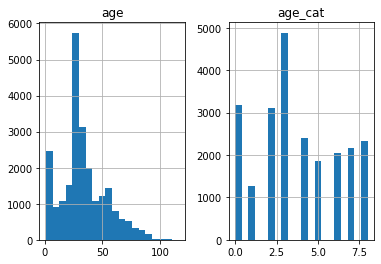

In [6]:
age_list = [0, 10, 18, 25, 30, 35, 40, 50, 60, 120]
ds_df['age_cat'] = pd.cut(ds_df['age'],bins = age_list, labels=False)
ds_df[['age', 'age_cat']].hist(bins=20)

In [0]:
df_train, df_valid = train_test_split(ds_df, test_size=0.2, random_state=42)

In [8]:
df_train

,filename,age,gender,eth,age_norm,age_cat
1771,/content/agedata_cut/15_1_0_20170104013549874.jpg,15,1,0,0.15,1
7609,/content/agedata_cut/30_0_0_20170117181217157.jpg,30,0,0,0.30,3
13883,/content/agedata_cut/1_0_2_20161219211823957.jpg,1,0,2,0.01,0
3323,/content/agedata_cut/70_1_0_20170110140702586.jpg,70,1,0,0.70,8
18258,/content/agedata_cut/28_1_4_20170117202604343.jpg,28,1,4,0.28,3
...,...,...,...,...,...,...
11964,/content/agedata_cut/1_0_2_20161219204409620.jpg,1,0,2,0.01,0
21575,/content/agedata_cut/45_0_2_20170120222541001.jpg,45,0,2,0.45,6
5390,/content/agedata_cut/29_1_3_20170119195154547.jpg,29,1,3,0.29,3
860,/content/agedata_cut/22_1_0_20170112233750014.jpg,22,1,0,0.22,2


In [0]:
def _parse_function(filename,labels):
    image_string = tf.io.read_file(filename) 
    image_decoded = tf.image.decode_jpeg(image_string, channels=3) # Channels needed because some test images are b/w
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    image_resized /= 255
    return image_resized, labels

In [0]:
# This snippet is adapted from here: https://www.tensorflow.org/guide/datasets
def input_fn(dataframe, is_eval=False):

    # Load the list of files
    filenames = tf.constant(dataframe['filename'].tolist())

    # Load the labels
    # Y_age = pd.get_dummies(dataframe['age_norm']).values.astype('int32')
    Y_age =dataframe['age_norm'].values.astype('float32')
    Y_gender = pd.get_dummies(dataframe['gender']).values.astype('int32')
    Y_eth = pd.get_dummies(dataframe['eth']).values.astype('int32')
    labels = {output_1: Y_age, output_2: Y_gender, output_3: Y_eth}

    # Build the dataset with image processing on top of it
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_parse_function)

    # Add shuffling and repeatition if training
    if is_eval:
      dataset = dataset.batch(batch_size)
    else:
      dataset = dataset.repeat().shuffle(1000).batch(batch_size)

    return dataset

In [0]:
ds_train = input_fn(df_train, is_eval=False)
ds_valid = input_fn(df_valid, is_eval=True)



In [0]:
for img, labels in ds_train.take(1):
    break

# Model

In [0]:
# class create_model(Model):
#     def __init__(self):
#         super(create_model, self).__init__()
#         self.MobileNet = tf.keras.applications.MobileNet()
#         self.conv1 = Conv2D(32, 3, activation='relu')
#         self.flatten = Flatten()
#         self.d1 = Dense(128, activation='relu')
#         self.d2 = Dense(10, activation='softmax')
#         self.d_age = Dense(9, activation = 'softmax',kernel_initializer='he_normal',dtype='float32', name='dense_age')
#         self.d_gender = Dense(2, activation = 'softmax',kernel_initializer='he_normal',dtype='float32', name='dense_gender')
#         self.d_eth = Dense(5, activation = 'softmax',kernel_initializer='he_normal',dtype='float32', name='dense_eth')
        
#         self.Dropout = tf.keras.layers.Dropout(0.1)

#     def call(self, x):
#         x = self.conv1(x)
#         # x = self.MobileNet(x)
#         x = self.flatten(x)
#         x = self.Dropout(x)
#         x = self.d1(x)
#         # x = self.Dropout(x)

#         head_age = Dense(9, activation = 'softmax',kernel_initializer='he_normal',dtype='float32', name='dense_age')(x)
#         head_gender = self.d_gender(x)
#         head_eth = self.d_eth(x)
#         return [head_age, head_gender, head_eth]
     

In [13]:
input_img = list(ds_train.take(1))[0][0]
input_img.shape

TensorShape([8, 224, 224, 3])

In [0]:
IMG_SIZE=224
N_CHANNELS = 3
input_shape = [IMG_SIZE,IMG_SIZE,N_CHANNELS]
inputs = Input(shape=input_shape)
conv1 = layers.Conv1D(filters=3, kernel_size=1)
out_img = conv1(list(ds_train.take(1))[0][0][0])

In [0]:
# # face-api agegendernet structure
# def denseBlock4(block_in):
#     out1 = layers.SeparableConv2D(filters=128, kernel_size = 3, strides=(2, 2),activation="relu")(block_in)
#     out2 = layers.SeparableConv2D(filters=128, kernel_size = 3, strides=(1, 1),padding="same")(out1)

#     in3 = layers.Activation(activation="relu")(layers.Add()([out1,out2]))
#     out3 = layers.SeparableConv2D(filters=128,kernel_size=3,strides=(1,1),padding="same")(in3)

#     in4 = layers.Activation(activation="relu")(layers.Add()([out2,out3]))
#     out4 = layers.SeparableConv2D(filters=128,kernel_size=3,strides=(1,1),padding="same")(in4)

#     out = layers.Activation(activation="relu")(layers.Add()([out3, out4]))

#     return out


# def forwardInput(block_in):
#     out = denseBlock4(block_in)
#     out = denseBlock4(out)
#     out = denseBlock4(out)
#     out = layers.AveragePooling2D(pool_size=(7,7), strides=(2,2),padding="valid")(out)
#     return out

# def face_api_create_model():
#     input_shape = [IMG_SIZE,IMG_SIZE,N_CHANNELS]
#     inputs = Input(shape=input_shape)

#     x = forwardInput(inputs)
#     x = layers.AveragePooling2D(pool_size=(7,7), strides=(2,2),padding="valid")(x)
#     x = layers.Flatten()(x)

#     head_age = layers.Dense(9, activation = 'softmax',kernel_initializer='he_normal',dtype='float32', name='output_1')(x)
#     head_gender = layers.Dense(2, activation = 'softmax',kernel_initializer='he_normal',dtype='float32', name='output_2')(x)
  
#     model = models.Model(inputs=inputs, outputs=[head_age, head_gender])
#     return model

# model = face_api_create_model()

In [0]:
# %%bash
# pip install tensorflow-js
# tensorflowjs_converter \
#     --input_format=tf_saved_model \
#     --output_node_names='MobilenetV1/Predictions/Reshape_1' \
#     --saved_model_tags=serve \
#     testsaved \
#     web_model

In [0]:
def create_model():
    input_shape = [IMG_SIZE,IMG_SIZE,N_CHANNELS]
    inputs = Input(shape=input_shape)


    # x = Conv2D(32, 3, activation='relu')(inputs)
    x = tf.keras.applications.MobileNetV2()(inputs)
    # x = Flatten()(x)
    x = Dropout(0.1)(x)
    x = Dense(256, activation='relu')(x)
    # x = self.Dropout(x)

    # x1 = Dense(128, activation = 'relu',kernel_initializer='he_normal',dtype='float32', name=output_1)(x)
    head_age = Dense(1, activation = 'relu',kernel_initializer='he_normal',dtype='float32', name=output_1)(x)
    head_gender = Dense(2, activation = 'softmax',kernel_initializer='he_normal',dtype='float32', name=output_2)(x)
    head_eth = Dense(5, activation = 'softmax',kernel_initializer='he_normal',dtype='float32', name=output_3)(x)

    model = Model(inputs=inputs, outputs=[head_age, head_gender, head_eth])
    return model
model = create_model()

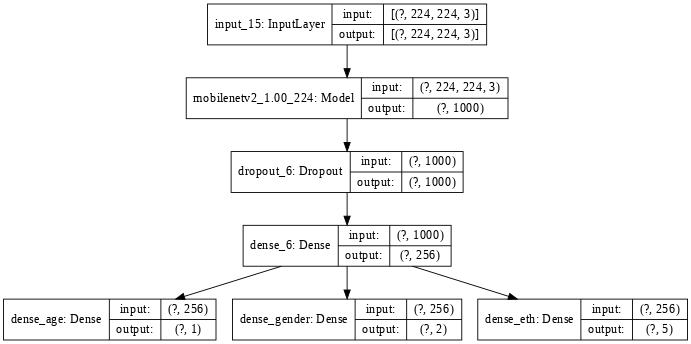

In [41]:
tf.keras.utils.plot_model(model,show_shapes=True, dpi=64)

In [0]:
# def lr_schedule(epoch):
#     lr = 1e-3
#     lr = 0.5*(1+np.cos((epoch/epoch_num)*np.pi))*lr
#     print('Learning rate: ', lr)
#     return lr

# lr_scheduler = LearningRateScheduler(lr_schedule)



In [42]:
def create_compiled_model():
    # initialize the optimizer and compile the model
    print("[INFO] compiling model...")

    model = create_model()

    losses = {
        output_1: "mean_squared_error",
        output_2: "categorical_crossentropy",
        output_3: "categorical_crossentropy",
    }
    lossWeights = {output_1:1,output_2: 1.0, output_3: 1.0}

    metrics = {
        output_1: "mean_absolute_error",
        output_2: "categorical_crossentropy",
        output_3: "categorical_crossentropy",
    }



    optimizer = Adam(lr=0.0001,amsgrad=True)

    model.compile(optimizer=optimizer, 
                loss=losses, 
                loss_weights=lossWeights,
                metrics=metrics)
    return model


model = create_compiled_model()
model.summary()

[INFO] compiling model...
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Model)    (None, 1000)         3538984     input_17[0][0]                   
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 1000)         0           mobilenetv2_1.00_224[1][0]       
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 256)          256256      dropout_7[0][0]                  
__________________________________________________________________

In [36]:
#tf.keras.utils.plot_model(tf.keras.applications.MobileNetV2(), show_shapes=True, dpi=64)
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

AttributeError: ignored

# Data augmentation

In [0]:
class GridMask():
    """GridMask augmentation for image classification and object detection.
    
    Author: Qishen Ha
    Email: haqishen@gmail.com
    2020/01/29

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        # super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

gm = GridMask(mode=0, num_grid=3)
gm.init_masks(IMG_SIZE,IMG_SIZE)
init_masks = tf.cast(gm.masks[0], dtype='float32')

# @tf.function
def add_mask(s):
    # random_angle = tf.random.uniform([1])[0]*np.pi
    # rotated_masks = tfa.image.rotate(init_masks, random_angle)
    # mask_single = tf.image.random_crop(rotated_masks,[IMG_SIZE,IMG_SIZE])

    mask_single = tf.image.random_crop(init_masks,[IMG_SIZE,IMG_SIZE])
    mask_batch = tf.reshape(mask_single, [1,IMG_SIZE,IMG_SIZE,1])

    s *= mask_batch
    return s


In [0]:
# add_mask(img)
# img.shape

In [0]:
# test = img[0,:,:,1]
# mask_single = tf.reshape(test, [1,IMG_SIZE,IMG_SIZE,1])
# mask_batch = tf.repeat(mask_single, repeats=batch_size, axis=0)
# mask_batch3d = tf.repeat(mask_batch, repeats=3, axis=3)

# mask_batch3d*mask_batch3d

In [0]:
def resize_image(s, L):
    s = tf.image.resize(s,
                        tf.constant([L,L]),
                        # method=tf.image.ResizeMethod.BICUBIC,
                        # antialias=True
                            )
    return s

def random_crop(s):
    s = resize_image(s, L=int(IMG_SIZE*1.2))
    s = tf.image.random_crop(s, [batch_size, IMG_SIZE, IMG_SIZE, N_CHANNELS])
    return s

def random_flip(s):
    if tf.random.uniform([1])[0]<0.5:
        s = tf.image.flip_left_right(s)
    return s

def color_jitter(s):
    s = tf.image.adjust_saturation(s, tf.random.uniform([1], 0.5,1.5)[0]) # saturation from 0.5 to 1.5
    s = tf.image.adjust_brightness(s, tf.random.uniform([1], -0.5, 0.5)[0]) # brightness from -0.4(dark) to 0.4(light)
    s = tf.clip_by_value(s, 0, 1)
    return s


## mixup v3  
def mix_up(s,b):
    alpha=1
    lamA = np.random.beta(alpha, alpha, [batch_size,1])
    lamB = 1-lamA
    ## Reorder according to permutation
    perm = tf.random.shuffle(tf.range(batch_size))
    sm = tf.gather(s, perm, axis=0)
    bm1 = tf.gather(b['dense_1'], perm, axis=0)
    bm2 = tf.gather(b['dense_2'], perm, axis=0)
    bm3 = tf.gather(b['dense_3'], perm, axis=0)

    b_out = {}
    s = lamA.reshape([-1,1,1,1])*s+lamB.reshape([-1,1,1,1])*sm
    b_out[output_1] = lamA*tf.cast(b[output_1], dtype='float32')+lamB*tf.cast(bm1, dtype='float32')
    b_out[output_2] = lamA*tf.cast(b[output_2], dtype='float32')+lamB*tf.cast(bm2, dtype='float32')
    b_out[output_3] = lamA*tf.cast(b[output_3], dtype='float32')+lamB*tf.cast(bm3, dtype='float32')
    
    return s, b_out


In [0]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

In [28]:
# i = 21
# ori = img[i]
# aug = add_mask(img)[i]
# visualize(ori,aug)

InvalidArgumentError: ignored

In [0]:
@tf.function
def mapped_function(s,b):
    if tf.random.uniform([1])[0]<0.75:
        s = random_crop(s)  
        s = random_flip(s)
        s = color_jitter(s)
        s = add_mask(s)
    else :
        s = random_crop(s)  
        s = random_flip(s)
        s = color_jitter(s)
    return s,b


In [0]:
# X_examples = list(ds_train.take(2).as_numpy_iterator())[0][0]
# y_examples = list(ds_train.take(2).as_numpy_iterator())[0][1]
# # image_examples = reshape_image(X_examples)
# # image_examples = resize_image(image_examples)
# image_examples = X_examples
# plt.figure(figsize=(10,10))
# for i in range(16):
#     image_plot = np.array(image_examples[i])
#     plt.subplot(4,4,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(image_plot, cmap=plt.cm.binary)
# plt.show()

# image_examples, target_examples = mapped_function(X_examples,y_examples)
# plt.figure(figsize=(10,10))
# for i in range(16):
#     image_plot = np.array(image_examples[i])
#     plt.subplot(4,4,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(image_plot, cmap=plt.cm.binary)
# plt.show()

# Training

In [0]:
## Callback
# learning rate
learning_rate_reduction_output_1 = ReduceLROnPlateau(monitor=f'{output_1}_loss', 
                                                 patience=3, verbose=1,
                                                 factor=0.5, min_lr=1e-5)

## checkpoint
filepath="weights-improvement-{epoch:02d}-{val_dense_age_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_dense_age_loss', verbose=1, save_best_only=True)

callbacks_list = [checkpoint]

## tensorboard
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# %load_ext tensorboard
# %tensorboard --logdir logs/scalars


In [0]:
history = model.fit(ds_train.map(mapped_function,num_parallel_calls=tf.data.experimental.AUTOTUNE), 
                    validation_data=ds_valid,
                    epochs=epoch_num, 
                    steps_per_epoch = df_train.shape[0] // batch_size,
                    validation_steps = df_valid.shape[0] // batch_size,
                    callbacks=[learning_rate_reduction_output_1, checkpoint,tensorboard_callback]
                    )

Epoch 1/60
2324/2324 [==============================] - ETA: 0s - loss: 1.9515 - dense_age_loss: 0.0376 - dense_gender_loss: 0.5581 - dense_eth_loss: 1.3558 - dense_age_mean_absolute_error: 0.1475 - dense_gender_categorical_crossentropy: 0.5581 - dense_eth_categorical_crossentropy: 1.3558
Epoch 00001: val_dense_age_loss improved from inf to 0.03105, saving model to weights-improvement-01-0.03.hdf5
2324/2324 [==============================] - 182s 78ms/step - loss: 1.9515 - dense_age_loss: 0.0376 - dense_gender_loss: 0.5581 - dense_eth_loss: 1.3558 - dense_age_mean_absolute_error: 0.1475 - dense_gender_categorical_crossentropy: 0.5581 - dense_eth_categorical_crossentropy: 1.3558 - val_loss: 1.6876 - val_dense_age_loss: 0.0310 - val_dense_gender_loss: 0.3822 - val_dense_eth_loss: 1.2744 - val_dense_age_mean_absolute_error: 0.1351 - val_dense_gender_categorical_crossentropy: 0.3822 - val_dense_eth_categorical_crossentropy: 1.2744 - lr: 1.0000e-04
Epoch 2/60
2324/2324 [====================

In [0]:
%matplotlib inline
def plot_loss(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure(figsize=(10,10)) 
    plt.plot(np.arange(0, epoch), his.history['loss'], 'k', label='train_loss')
    plt.plot(np.arange(0, epoch), his.history[f'{output_1}_loss'], 'r', label=f'train_{output_1}')
    plt.plot(np.arange(0, epoch), his.history[f'{output_2}_loss'], 'g', label=f'train_{output_2}')
    plt.plot(np.arange(0, epoch), his.history[f'{output_3}_loss'], 'b', label=f'train_{output_3}')
    
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_1}_loss'], 'r--', label=f'val_{output_1}')
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_2}_loss'], 'g--', label=f'val_{output_2}')
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_3}_loss'], 'b--', label=f'val_{output_3}')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure(figsize=(10,10))
    plt.yticks(np.arange(0.1,1.05,0.01))
    plt.xticks(np.arange(0,61,1))
    plt.plot(np.arange(0, epoch), his.history[f'{output_1}_accuracy'], 'r', label=f'train_{output_1}')
    plt.plot(np.arange(0, epoch), his.history[f'{output_2}_accuracy'], 'g', label=f'train_{output_2}')
    plt.plot(np.arange(0, epoch), his.history[f'{output_3}_accuracy'], 'b', label=f'train_{output_3}')
    
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_1}_accuracy'], 'r--', label=f'val_{output_1}')
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_2}_accuracy'], 'g--', label=f'val_{output_2}')
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_3}_accuracy'], 'b--', label=f'val_{output_3}')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

In [0]:
plot_acc(history, epoch_num, 'Training Dataset: ')
plot_loss(history, epoch_num, 'Training Dataset: ')

plt.figure()
plt.plot(history.epoch, history.history['lr'])

In [0]:
# %load_ext tensorboard
# %tensorboard --logdir logs/scalars

In [0]:
# PATH = '/content/drive/My Drive/Colab Notebooks/age_classification/save_weights'
# # model.save_weights(PATH+"/resnext20_80epochs.h5")
# model.save_weights(PATH+f"/MobileNet2_V4.h5")

In [0]:
!ls /content/drive/My\ Drive/Colab\ Notebooks/age_classification

In [0]:
history.history

In [0]:
!ls

In [0]:
!pip install face_recognition
import face_recognition

In [0]:

image = cv2.imread('/content/test.jpg')[...,::-1]
face_locations = face_recognition.face_locations(image)

if len(face_locations)==1:
    top, right, bottom, left = face_locations[0]
    # print('top, right, bottom, left:',top, right, bottom, left)
    weight = right-left
    hight = bottom-top

    x_pad = weight//2
    y_pad = hight//2

    left = left-x_pad if (left-x_pad)>0 else 0
    right = right+x_pad if (right+x_pad)<image.shape[1]  else image.shape[1]
    top = top-y_pad if (top-y_pad)>0 else 0
    bottom = bottom+y_pad if (bottom+y_pad)<image.shape[0] else image.shape[0]

    face_cut = image[top:bottom, left:right]

image_test = tf.image.resize(face_cut, [IMG_SIZE, IMG_SIZE])/255
image_test = tf.reshape(image_test, [1, IMG_SIZE, IMG_SIZE, 3])
# model(image_test)
age_class = np.argmax(model(image_test)[0])
print(age_list[age_class])
plt.imshow(image_test[0])


In [0]:
i = 45
age_class = np.argmax(model(img)[0][i])
print(age_list[age_class])
plt.imshow(img[i])


In [0]:
age_list